In [1]:
# Install Libraries
!sudo pip3 install contractions
!sudo pip3 install textsearch
!sudo pip3 install tqdm
!sudo pip3 install nltk
!sudo pip3 install beautifulsoup4
import nltk
nltk.download('punkt')

     |████████████████████████████████| 317kB 19.4MB/s 
     |████████████████████████████████| 245kB 46.4MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81698 sha256=73a5bfb868aeeb86423cb352b7ac35d708d070a0f2d3c5c0d9ab8bfd8761b773
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding
print(tf.__version__)
import io
import os

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)


2.3.0


In [3]:
# upload data 
from google.colab import files
uploaded = files.upload()

Saving movie_reviews.csv.bz2 to movie_reviews.csv.bz2


In [4]:
# MovieReviews = pd.read_csv(r'https://github.com/sandhyaparna/NLP/blob/main/Data/movie_reviews.csv.bz2', compression='bz2')
MovieReviews = pd.read_csv(io.BytesIO(uploaded['movie_reviews.csv.bz2']), compression='bz2')
print(f'MovieReviews is loaded')

MovieReviews is loaded


In [5]:
# Summary
print(MovieReviews.head())
print(pd.unique(MovieReviews['sentiment']))
MovieReviews.info()

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
['positive' 'negative']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
# Positive sentiment is coded as 1 and negative is coded as 0
MovieReviews['sentiment'] = np.where(MovieReviews['sentiment']=="positive",1,0)
pd.value_counts(MovieReviews['sentiment'])

1    25000
0    25000
Name: sentiment, dtype: int64

In [7]:
# Text 
MovieReviews['review'].values

array(["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to

In [21]:
# Split data into Train, Validation & Test
reviews = MovieReviews['review'].values
sentiments = MovieReviews['sentiment'].values

training_size = int(len(reviews)*0.45)
valid_size = int(len(reviews)*0.65)

train_reviews = reviews[:training_size]
val_reviews = reviews [training_size:valid_size]
test_reviews = reviews[valid_size:]

train_sentiments = sentiments[:training_size]
val_sentiments = sentiments [training_size:valid_size]
test_sentiments = sentiments[valid_size:]

train_reviews.shape, val_reviews.shape, test_reviews.shape

((22500,), (10000,), (17500,))

In [9]:
# Pre-process/Clean Data
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        doc = strip_html_tags(doc)
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = remove_accented_chars(doc)
        doc = contractions.fix(doc)
        # lower case and remove special characters\whitespaces
        doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc, re.I|re.A)
        doc = re.sub(' +', ' ', doc)
        doc = doc.strip()  
        norm_docs.append(doc)
    return norm_docs

In [22]:
# Apply pre-processing
process_train_texts = pre_process_corpus(train_reviews)
process_val_texts = pre_process_corpus(val_reviews)
process_test_texts = pre_process_corpus(test_reviews)

100%|██████████| 17500/17500 [00:08<00:00, 2155.43it/s]


(0.0, 2000.0)

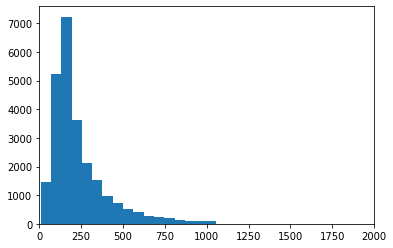

In [11]:
# Histogram of length of reviews in Train data
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([len(doc.split()) for doc in process_train_texts], bins=30);
plt.xlim([0, 2000])

In [12]:
# maxlen (for padding) can be chosen based on the histogram of length of reviews in Train data
max_length = 500
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [23]:
# Apply padding to sentence so each sentence is of same length
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(process_train_texts)

word_index = tokenizer.word_index

train_sequences  = tokenizer.texts_to_sequences(process_train_texts)
train_padded = pad_sequences(train_sequences , maxlen=max_length, padding=padding_type, truncating=trunc_type)

val_sequences  = tokenizer.texts_to_sequences(process_val_texts)
val_padded = pad_sequences(val_sequences , maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(process_test_texts)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

### Word2vec Embeddings

In [14]:
# Import word2vec pre-embeddings
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip
!unzip wiki-news-300d-1M-subword.vec.zip

--2020-11-20 01:18:10--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 587879973 (561M) [application/zip]
Saving to: ‘wiki-news-300d-1M-subword.vec.zip’

wiki-news-300d-1M-s 100%[===================>] 560.65M  23.5MB/s    in 25s     

2020-11-20 01:18:36 (22.7 MB/s) - ‘wiki-news-300d-1M-subword.vec.zip’ saved [587879973/587879973]

Archive:  wiki-news-300d-1M-subword.vec.zip
  inflating: wiki-news-300d-1M-subword.vec  


In [15]:
# path of the downloaded embedding vectors
!ls
!pwd

movie_reviews.csv.bz2  wiki-news-300d-1M-subword.vec
sample_data	       wiki-news-300d-1M-subword.vec.zip
/content


In [16]:
# prepare embedding matrix to use in keras embedding layer
def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):    
    
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*row.split(" ")) 
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore') 
                                    if len(row)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
    
    for word, idx in word_to_index.items():
        if idx >= max_features: 
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [17]:
# Variables
path_to_embedding_file = "wiki-news-300d-1M-subword.vec"
word2index = word_index
vocab_size = len(word_index)
embed_size = 300
n_epochs=100
batches=128

In [24]:
# Apply load_pretrained_embeddings on train data/ word_index
Train_embedding_matrix = load_pretrained_embeddings(word_to_index=word2index, 
                                           max_features=vocab_size, 
                                           embedding_size=embed_size, 
                                           embedding_file_path=path_to_embedding_file)
Train_embedding_matrix.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(77558, 300)

In [25]:
# create the model
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(vocab_size, embed_size,
                                    weights=[Train_embedding_matrix],
                                    trainable=True,
                                    input_length=max_length))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          23267400  
_________________________________________________________________
flatten_1 (Flatten)          (None, 150000)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               38400256  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [26]:
# Fit the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=3,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(train_padded, train_sentiments, 
          validation_data=(val_padded, val_sentiments),
          epochs=n_epochs, 
          batch_size=batches, 
          shuffle=True,
          callbacks=[callback],
          verbose=1)

Epoch 1/100
176/176 [==============================] - 48s 274ms/step - loss: 0.5576 - accuracy: 0.6896 - val_loss: 0.3088 - val_accuracy: 0.8726
Epoch 2/100
176/176 [==============================] - 48s 273ms/step - loss: 0.1578 - accuracy: 0.9433 - val_loss: 0.3067 - val_accuracy: 0.8724
Epoch 3/100
176/176 [==============================] - 48s 272ms/step - loss: 0.0154 - accuracy: 0.9959 - val_loss: 0.5707 - val_accuracy: 0.8687
Epoch 4/100
176/176 [==============================] - 48s 271ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.7199 - val_accuracy: 0.8698
Epoch 5/100
176/176 [==============================] - 48s 271ms/step - loss: 2.1997e-04 - accuracy: 1.0000 - val_loss: 0.7971 - val_accuracy: 0.8690
Epoch 00005: early stopping


In [27]:
# Performance on Test data
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

predictions = model.predict_classes(test_padded, batch_size=2048, verbose=0).ravel()

print("Accuracy: %.2f%%" % (accuracy_score(test_sentiments, predictions)*100))
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Accuracy: 87.15%
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      8755
           1       0.87      0.88      0.87      8745

    accuracy                           0.87     17500
   macro avg       0.87      0.87      0.87     17500
weighted avg       0.87      0.87      0.87     17500



,0,1
0,7593,1162
1,1086,7659
